## Coding for Lecture VI

by *Suwichaya Suwanwimolkul, Ph.D.*

The coding exercies and examples are used as parts of  *Lecture VI: LMSE, Wiener Filtering, Maximum A Posteriori*  in **Estimation Theory EE2102523**. 

The topics covered in this exercise are: 
- [Wiener Filtering](#wiener-filter)  
    - [Initialization](#initial-settings)
    - [Wiener Filter Algorithm](#wiener-filter-algorithm)
    - [Apply Wiener Fitler](#apply-wiener-filter)
- [Maximum A Posteriori Estimation](#maximum-a-posteriori-estimation)


Note: Don't forget to do `pip install -r requirements.txt`

References:

1. How to check https://online.stat.psu.edu/stat510/
2. Coding (in matlab version): https://dspcookbook.github.io/ ...


In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np
from scipy.linalg import toeplitz 
import pdb

## Wiener Filtering

Important Assumption: 

- Signal and (additive) noise are stationary

- They have known spectral characteristics or known autocorrelation and cross-correlation.

Therefore, we will perform the following checking on our generated signals to simulate the excericse in the lecture note. 


### Initializatoin  

**Simulating the target signal**

We want to extract $X[n]$ with autocorrelation $R_{xx}[k] = 0.95^{|k|}$ which is wide-sense stationary.  

In [2]:
def Rxx_function(a, var_x, tau):
    rxx     = var_x*(a**abs(tau))
    return rxx

In [3]:
# Generate a time-series signal x and our system will observe y  
N       = 10000
var_x    = 1
var_v    = 2
a       = 0.95
num_filter_coeff  = 3  

# Synthesize x[n] as a time-series data with auto correlation 0.95^{|k|}
u       = np.sqrt(var_x)*np.random.randn(N)   
x       = [0]   

# Generate the noisy time-series data
for n in range(1,N):
    x.append(a*x[n-1] + u[n])  # auto correlation 0.95^{|k|} 

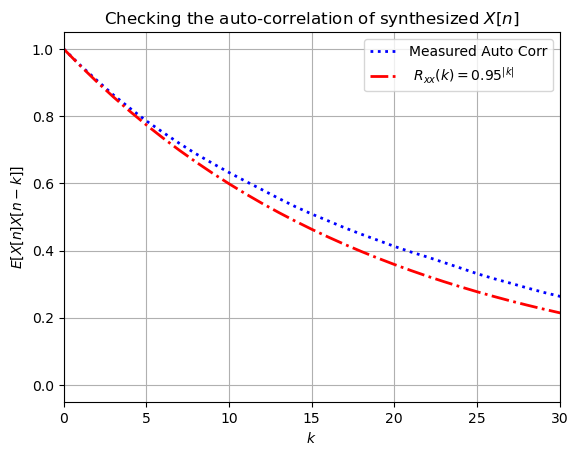

In [4]:
# Check the auto correlation.
import statsmodels.api as sm
x_array = np.array(x)
auto_corr       = sm.tsa.acf(x_array)
k               = np.arange(N)
auto_corr_func  = Rxx_function(a, var_x, k)


plt.plot(auto_corr, ":b", linewidth=2, label="Measured Auto Corr")
plt.plot(auto_corr_func, "-.r", linewidth=2, label=" $R_{xx} (k) = 0.95^{|k|}$ ")
plt.xlim(0,30) 
plt.ylabel("$E[X[n] X[n-k]]$")
plt.xlabel("$k$")
plt.title("Checking the auto-correlation of synthesized $X [n]$")
plt.grid()
plt.legend()

**Simulating the observations**

Nevertheless, we observed its noisy version $Y[n]$ where $Y[n] = X[n] + V[n]$ with variance $\sigma_V^2 = 2$ and $R_{vv}[k] = 2 \delta[k]$. 

$X[n]$ and $V[n]$ are uncorrelated, zero mean, jointly wide-sense stationary random process.    

In [5]:
# v is observation noise
v       = np.sqrt(var_v)*np.random.randn(N) 
# Our filter will observe y = x + n
y       = x + v  

In [6]:
def Ryx_function(var_x, a, k):
    ryx     = var_x*(a**abs(k))
    return ryx

def Ryy_function(var_x, a, var_v, k):
    delta = np.zeros_like(k)
    delta[0] = var_v
    ryy     = var_x*(a**abs(k)) + delta
    return ryy 

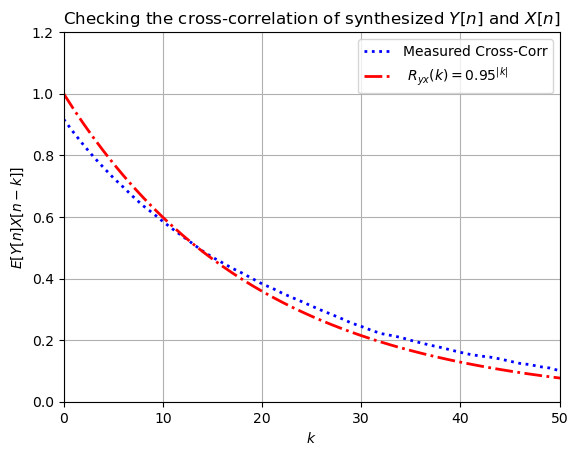

In [7]:
# Check the cross-correlation.
import statsmodels.api as sm

k               = np.arange(N)
auto_corr_func  = Ryx_function(var_x, a, k) 
r_yx_sim        = sm.tsa.stattools.ccf(x,y)

plt.plot(r_yx_sim, ":b", linewidth=2, label="Measured Cross-Corr")
plt.plot(auto_corr_func, "-.r", linewidth=2, label=" $R_{yx} (k) = 0.95^{|k|}$ ")
plt.xlim(0,50) 
plt.ylim(0,1.2) 
plt.ylabel("$E[Y[n] X[n-k]]$")
plt.xlabel("$k$")
plt.title("Checking the cross-correlation of synthesized $Y [n]$ and $X [n]$")
plt.grid()
plt.legend()

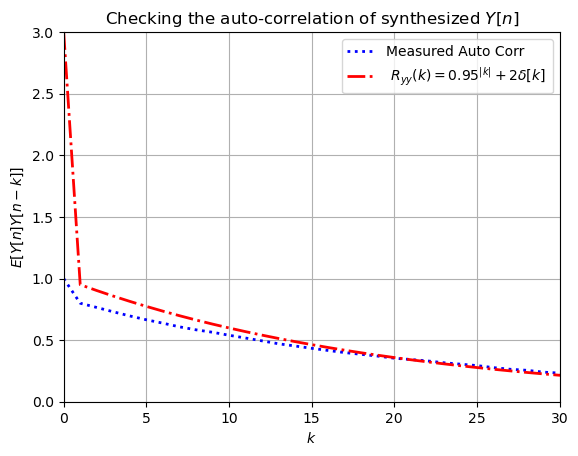

In [8]:
# Check the cross-correlation.
import statsmodels.api as sm

k               = np.arange(N)
auto_corr_func  = Ryy_function(var_x, a, var_v, k) 
r_yx_sim        = sm.tsa.acf(y)

plt.plot(r_yx_sim, ":b", linewidth=2, label="Measured Auto Corr")
plt.plot(auto_corr_func, "-.r", linewidth=2, label=" $R_{yy} (k) = 0.95^{|k|} + 2 \delta [k]$ ")
plt.xlim(0,30) 
plt.ylim(0,3) 
plt.ylabel("$E[Y[n] Y[n-k]]$")
plt.xlabel("$k$")
plt.title("Checking the auto-correlation of synthesized $Y [n]$")
plt.grid()
plt.legend()

### Wiener Filter Algorithm

In [9]:
# Wiener Filter algorithm 

def wiener_filt( y, param_Rxx = [a, var_x],  var_v=var_v, M = num_filter_coeff):
    
    # Step 1: Initialization
    a       = param_Rxx[0]
    var_x   = param_Rxx[1]

    tau     = np.arange(0,M)      
    rnn     = np.zeros_like(tau)
    rnn[0]  = var_v;             # Autocorrelation is a Kronecker Delta function 
    
    # Step 2.
    rxx     = Rxx_function(a, var_x, tau )
    # Step 3
    ryy     = rxx + rnn            # Autocorrelation vector 
    # Step 4
    Ryy     = toeplitz(ryy);       # Autocorrelation matrix  
    # Step 5
    ryx     = rxx  
    # Step 6 
    a_      = np.linalg.inv(Ryy).dot(ryx)  
    # Step 7 
    g = []
    for n_ in range(M-1,N):
        g.append(a_.dot(np.flipud(y[(n_-M+1):n_+1])))

    return np.array(g), a_

### Apply Wiener Filter

In [10]:

g, a_ = wiener_filt( y, param_Rxx = [a, var_x],  var_v=var_v, M = num_filter_coeff)
print("Filter Coefficients:", a_)

Filter Coefficients: [0.22028816 0.19187074 0.17380425]


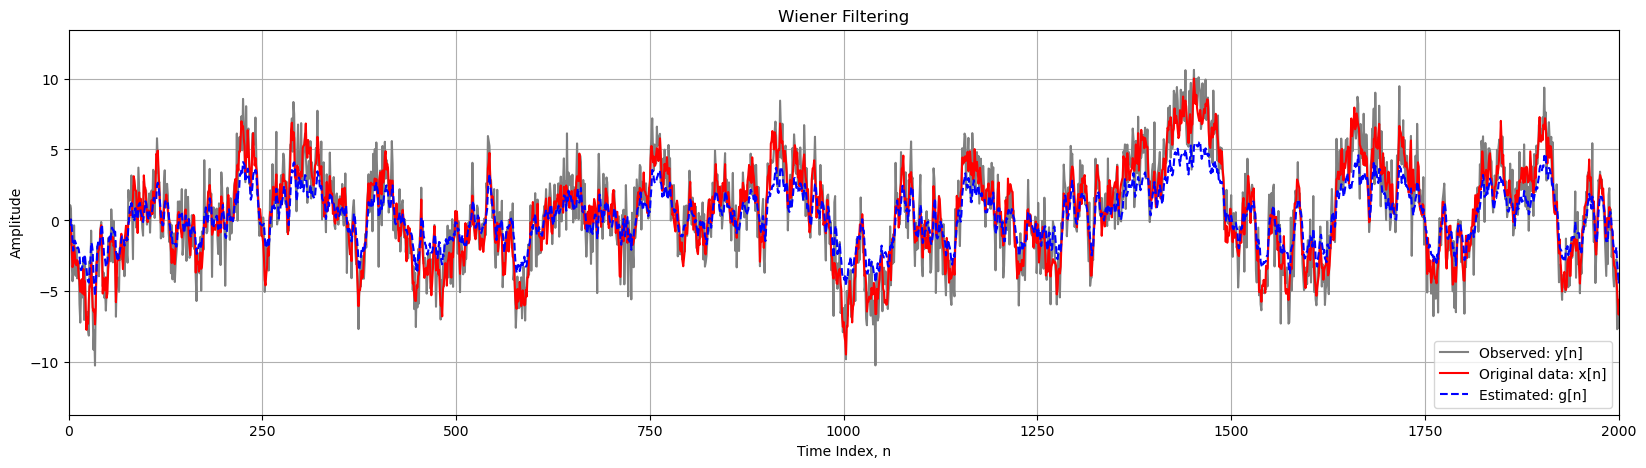

In [11]:
plt.figure(figsize=[20,5])

stime_index = np.arange(0,N)
ytime_index = np.arange(num_filter_coeff-1,N)
# Plot result
plt.plot(stime_index, y, label="Observed: y[n]", color="gray")
plt.plot(stime_index, x, label="Original data: x[n]", color="red") 
plt.plot(ytime_index, g, label="Estimated: g[n]", linestyle= '--', color="blue")
plt.grid()

plt.xlim([0,2000])
plt.legend() #'y(n)','g(n)','x(n)'
plt.xlabel("Time Index, n")
plt.ylabel("Amplitude")
plt.title('Wiener Filtering')
plt.show()

## Maximum A Posteriori Estimation